In [1]:
import itertools

import networkx as nx
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize": (16, 6)})
pal = sns.color_palette()

# Data loading

In [2]:
b = pd.read_csv('tracking_data/behavior.csv')

In [3]:
colmap = dict(zip(np.unique(b.group_period1), 
                  np.arange((len(np.unique(b.group_period1))))))

In [4]:
pal = sns.color_palette(palette=None, n_colors=len(np.unique(b.group_period1)))

In [5]:
labelmap = {'N': 'nurses', 'C': 'cleaners', 'F': 'foragers', 'Q': 'queen'}

In [6]:
colony_map = {1: 4, 2: 18, 3:21, 4:29, 5:58, 6:78}

In [7]:
period_start_days = (1, 12, 22, 32)

def get_period(day):
    if day < period_start_days[1]:
        return 1
    elif day < period_start_days[2]:
        return 2
    elif day < period_start_days[3]:
        return 3
    else:
        return 4

period_map = dict([(day, get_period(day)) for day in range(1, 42)])

In [8]:
def get_unknown_nodes(g, col_id):
    unknown_nodes = []
    for i in g.nodes():    
        if int(i) not in [int(j) for j in (b[b.colony == col_id]).tag_id]:
            unknown_nodes.append(i)
    return unknown_nodes

def get_attribute_dict(col_id, nodes, attribute):
    attributes = dict(zip(b[b.colony == col_id].tag_id, b[b.colony == col_id][attribute]))
    return dict((str(k), v) for k, v in attributes.items() if k in [int(n) for n in nodes])

def read_network(path, col_id):
    # read adjacency matrix
    nw = pd.read_csv(path)
    nw.set_index(nw.columns, inplace=True)
    
    # coloumn id == row id
    mapping = dict(zip(range(len(nw.columns)), [l.split('Ant')[1] for l in nw.columns]))
    g = nx.Graph(data=nw.as_matrix())
    nx.relabel_nodes(g, mapping, copy=False)
    
    # for some reason, some ids do not exist in behaviour data
    g.remove_nodes_from(get_unknown_nodes(g, col_id))
    
    # add behavioural meta data to nodes
    for attr in [attr for attr in b.columns if attr not in ('colony', 'tag_id')]:
        nx.set_node_attributes(g, attr, get_attribute_dict(col_id, g.nodes(), attr))
        
    return g

# Network visualization

In [9]:
def plot_colony(col_id, day, pos=None):
    g = read_network('tracking_data/network_col{}_day{}.txt'.format(col_id, day), colony_map[col_id])
    
    fig, ax = plt.subplots(figsize=(16, 12))

    edges = [(u, v) for u,v in g.edges() if g[u][v]['weight'] > 20]
    weights = [g[u][v]['weight'] for u,v in edges]
    weights = np.array(weights) / np.max(weights)
    connected_nodes = list(set(itertools.chain(*edges)))

    sg = g.subgraph(connected_nodes)

    node_sizes = np.array([v['body_size'] for k, v in sg.node.items()])
    node_sizes /= np.max(node_sizes)
    node_sizes = np.power(node_sizes, 2)
    node_sizes /= np.max(node_sizes)
    node_sizes *= 3000

    node_colors = [colmap[sg.node[n]['group_period{}'.format(period_map[day])]] for n in sg.nodes()]

    pos = nx.layout.spring_layout(g, k=0.6, pos=pos)

    nx.draw_networkx_labels(sg, pos=pos, ax=ax)

    for nt in np.unique(b.group_period1):
        nlist = [n for n in sg.nodes() if sg.node[n]['group_period{}'.format(period_map[day])] == nt]
        ncolor = colmap[nt]

        nx.draw_networkx_nodes(sg, 
                               node_size=[s for i, s in enumerate(node_sizes) if list(sg.node.keys())[i] in nlist], 
                               nodelist=nlist,
                               node_color=pal[ncolor], 
                               alpha=0.85,
                               linewidths=0.3, 
                               pos=pos,
                               label=labelmap[nt],
                               ax=ax)

    nx.draw_networkx_edges(sg, edgelist=edges, edge_color=[np.array([0., 0., 0., w]) for w in weights], width=4*weights, pos=pos, ax=ax)

    ax.set_axis_off()

    lgnd = ax.legend(labelspacing=1, fontsize=16)
    for hndl in lgnd.legendHandles:
        hndl._sizes = [300]

    fig.suptitle('Colony {} / Day {}'.format(col_id, day), fontsize=20)
    
    return pos

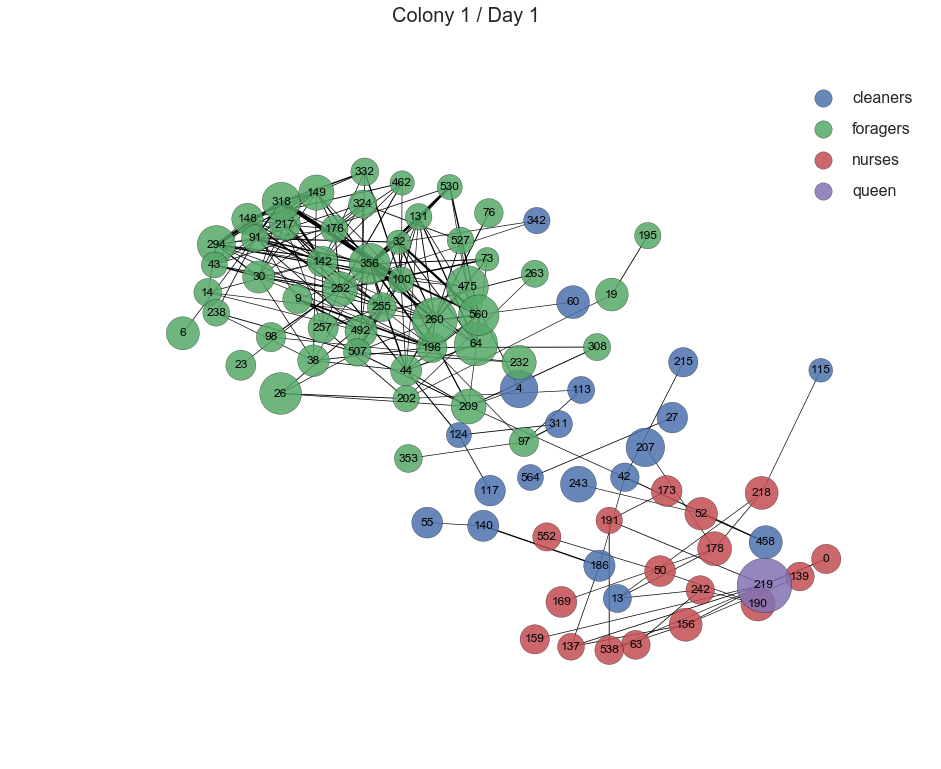

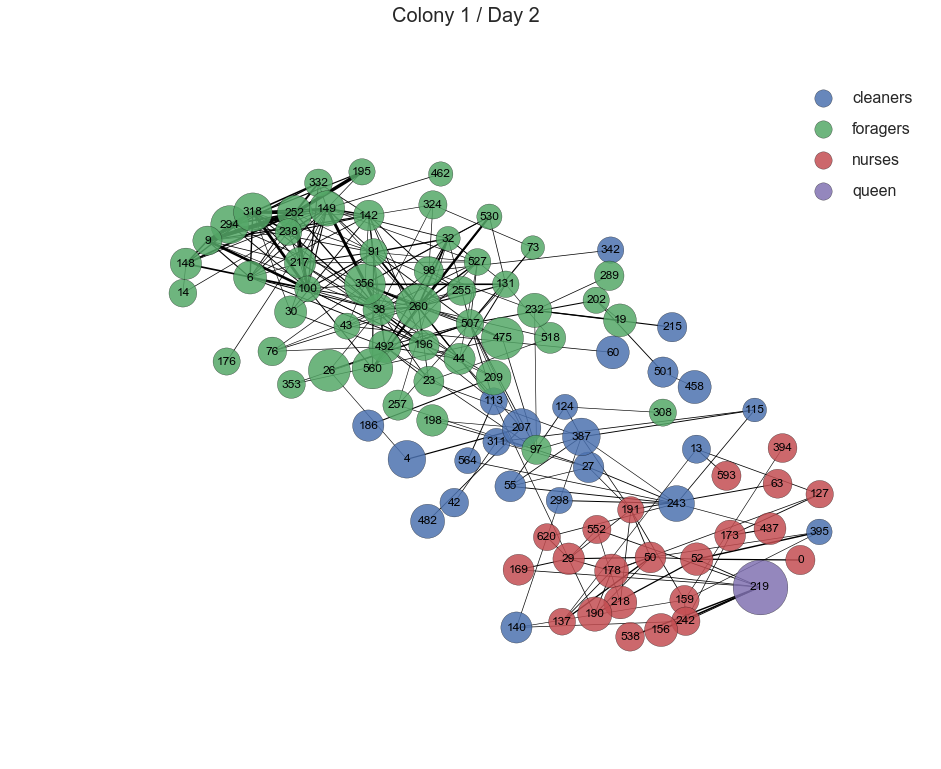

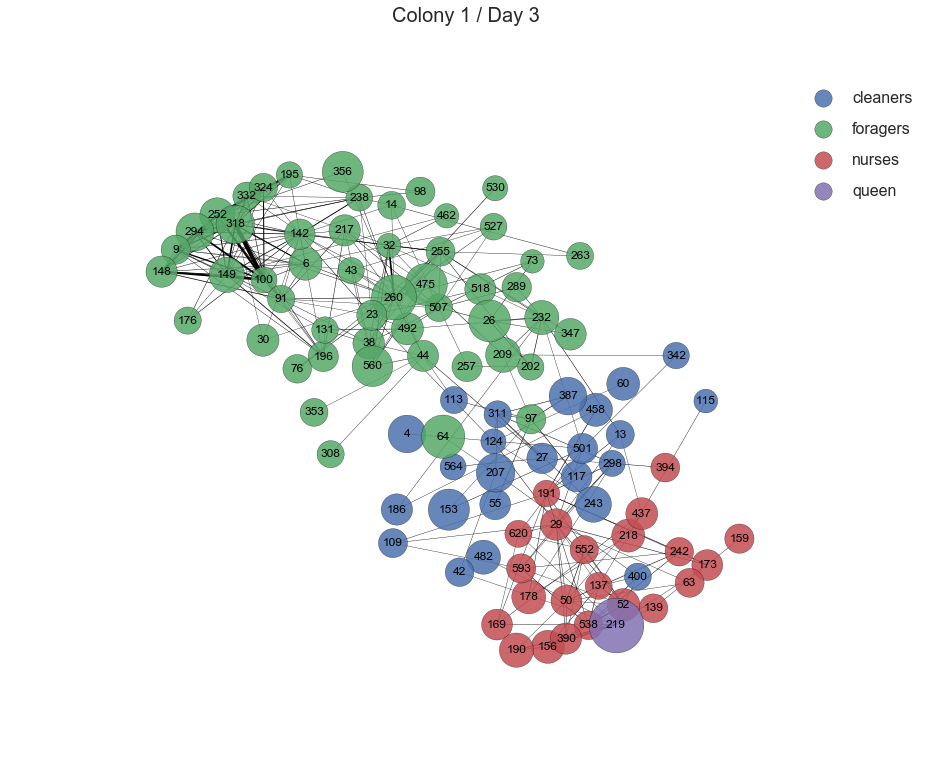

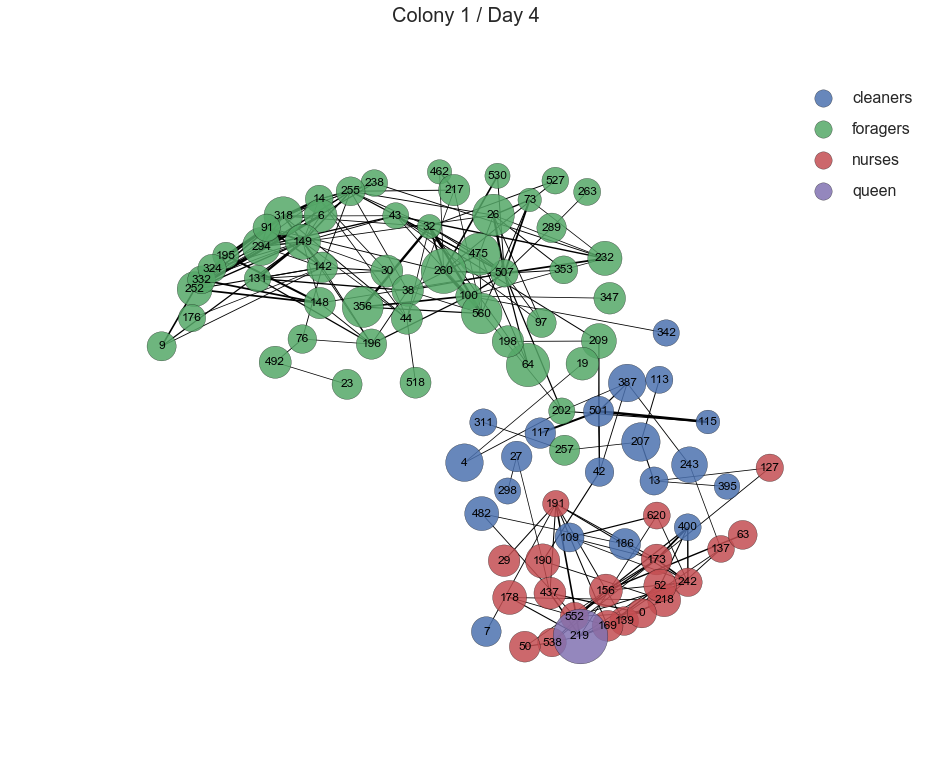

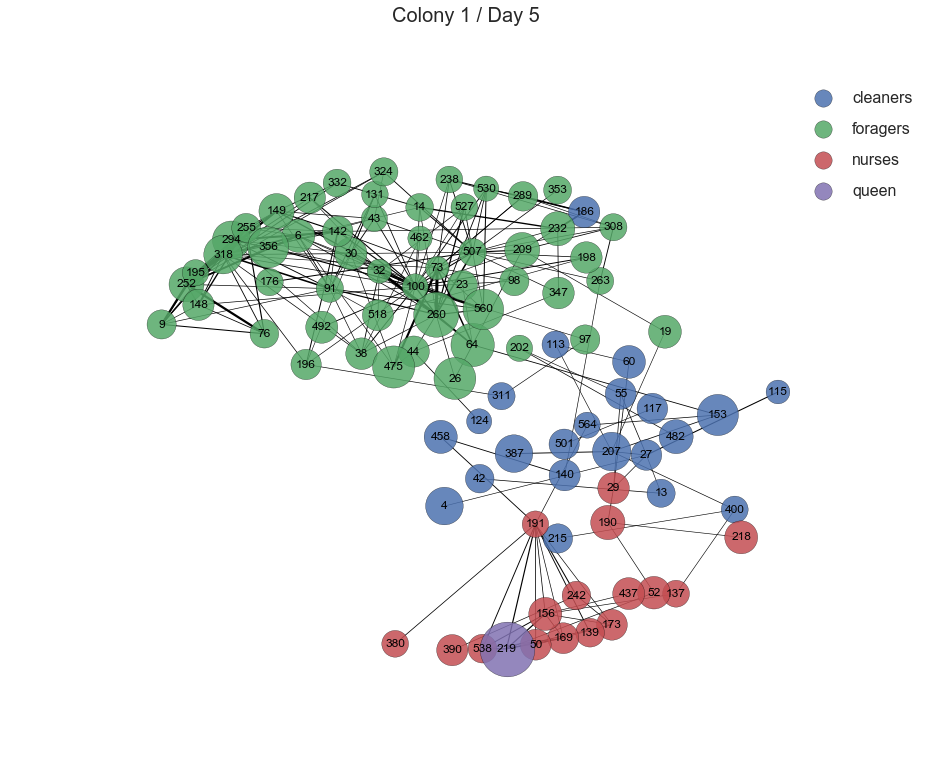

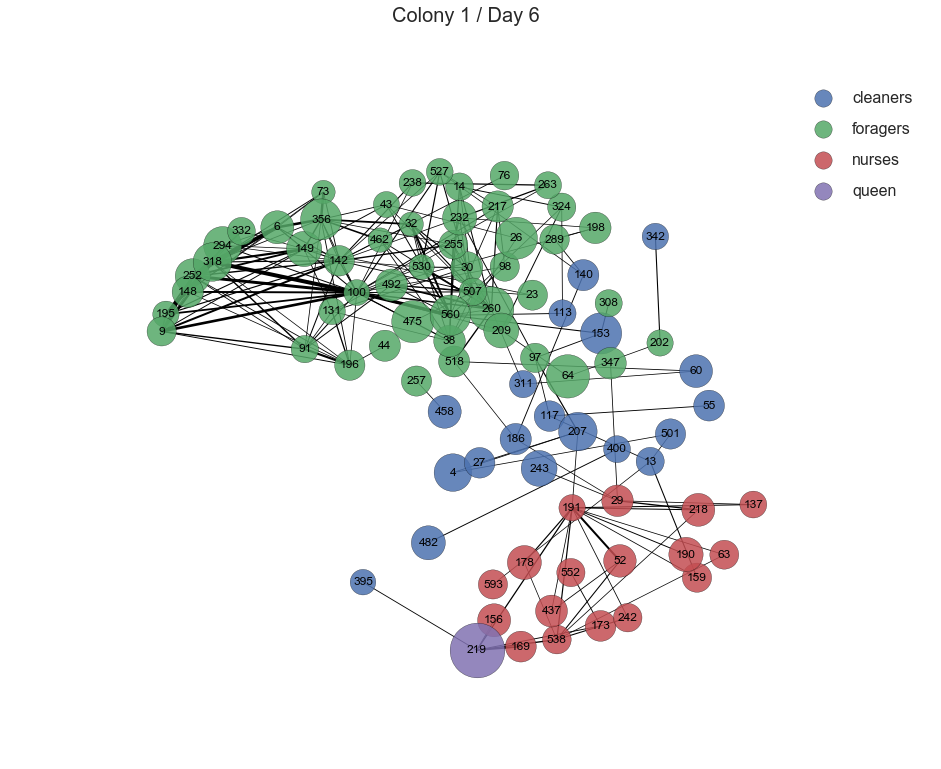

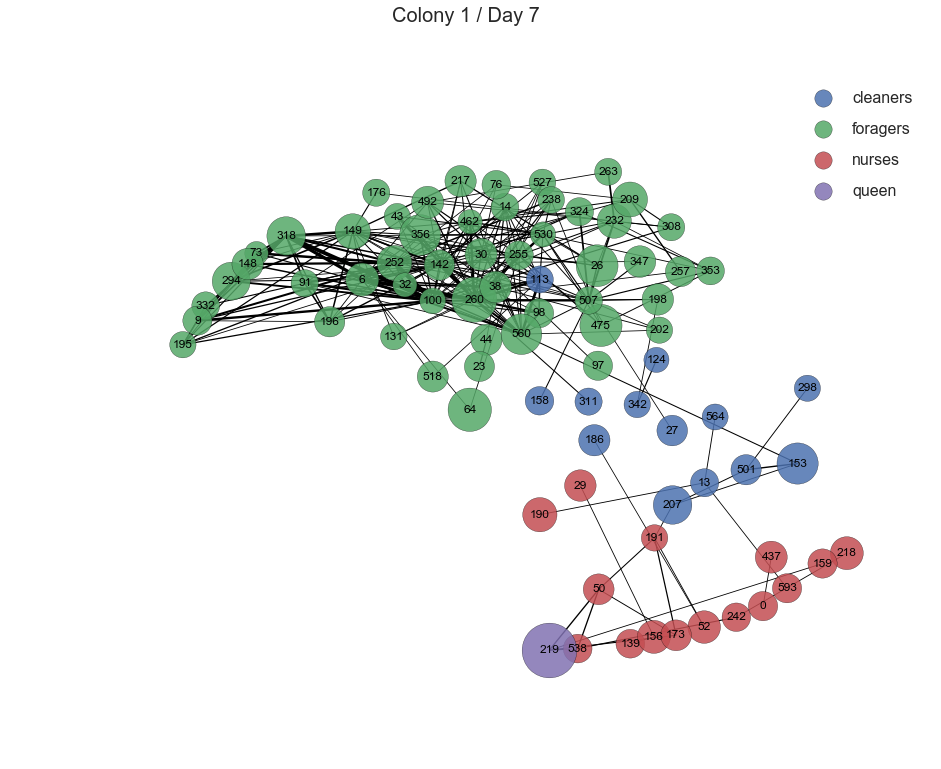

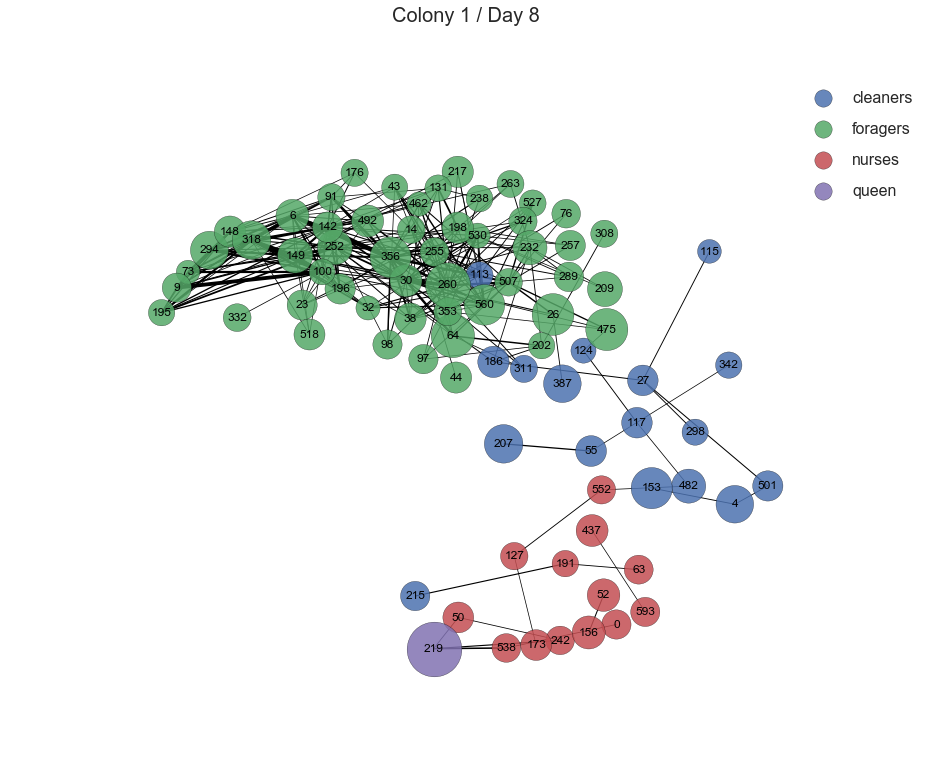

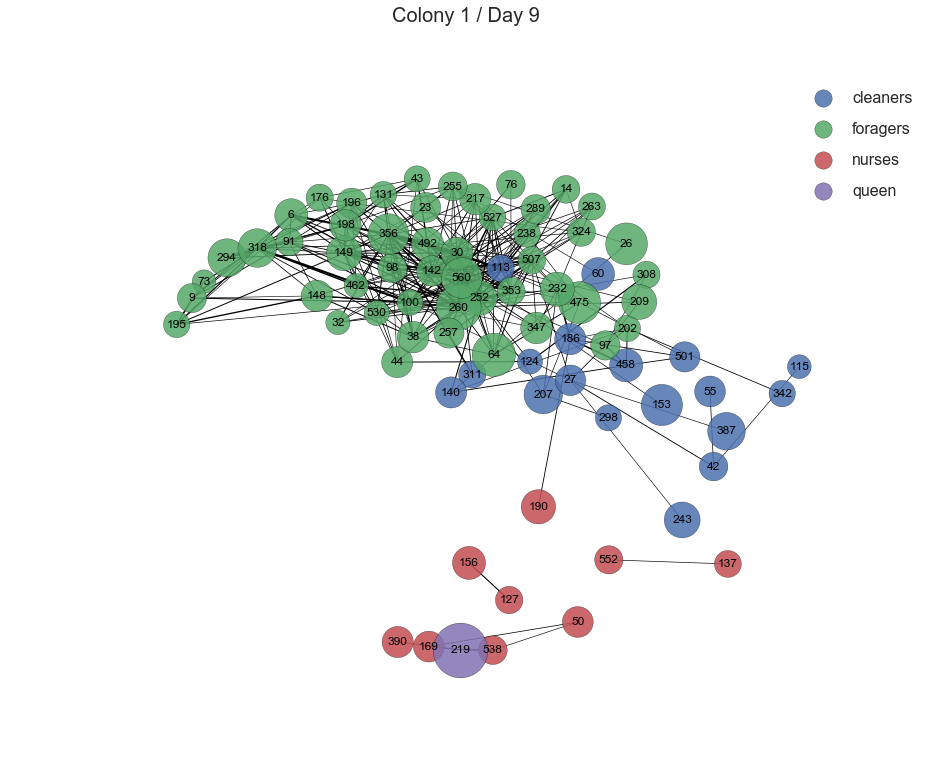

In [10]:
pos = None
for day in range(1, 10):
    pos = plot_colony(1, day, pos)
    plt.show()

# Network analysis

In [11]:
freqs = []
for col_id in range(1, 7):
    groups = []
    for day in period_start_days:
        g = read_network('tracking_data/network_col{}_day{}.txt'.format(col_id, day), colony_map[col_id])
        groups.append(dict([(n, g.node[n]['group_period{}'.format(period_map[day])]) for n in list(g.nodes_iter())]))
    groups = pd.DataFrame(groups, dtype="category")
    
    group_counts = []
    for d in groups.iterrows():
        d = d[1].astype("category")
        group_counts.append(d.value_counts())
        
    group_counts = pd.DataFrame(group_counts)
    group_freqs = group_counts.div(group_counts.sum(axis=1), axis=0)
    
    freqs.append(group_freqs)

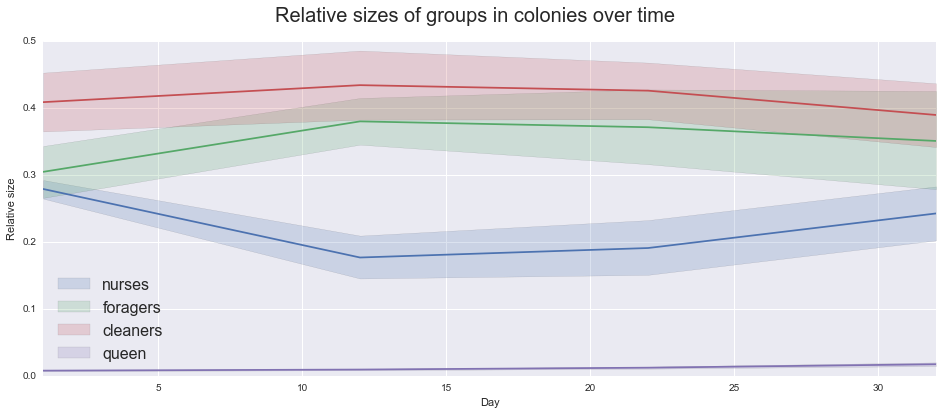

In [20]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.tsplot(time=period_start_days, data=np.stack(freqs), ax=ax)
ax.legend([labelmap[k] for k in group_freqs.columns], fontsize=16, loc='best')
ax.set_xlabel('Day')
ax.set_ylabel('Relative size')
_ = fig.suptitle('Relative sizes of groups in colonies over time', fontsize=20)